In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

### Vacation Dates
* The vacation will run from February 12-15 for a four-day long weekend over the President's day holiday in 2021

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# determine the columns for each table in database

# first, get the measurement columns
measurement_example = session.query(Measurement).first()
print(measurement_example.__dict__)

# next, get the station columns
station_example = session.query(Station).first()
print(station_example.__dict__)

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x0000017709D1FA88>, 'prcp': 0.08, 'station': 'USC00519397', 'date': '2010-01-01', 'id': 1, 'tobs': 65.0}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x0000017709D38788>, 'name': 'WAIKIKI 717.2, HI US', 'longitude': -157.8168, 'id': 1, 'station': 'USC00519397', 'latitude': 21.2716, 'elevation': 3.0}


('2010-01-01',)
('2017-08-23',)
The date one year before the final date is 2016-08-23 according the results of the query.


,prcp
date,
2016-08-23,1.79
2016-08-24,2.28
2016-08-25,0.21
2016-08-26,0.04
2016-08-27,0.18
...,...
2017-08-19,0.09
2017-08-20,0.01
2017-08-21,0.56


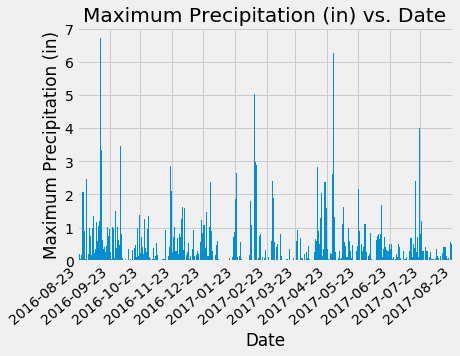

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
final_date = session.query(Measurement.date).order_by(Measurement.date.desc())[0]
first_date = session.query(Measurement.date).order_by(Measurement.date.desc())[-1]
print(first_date)
print(final_date)
print("The date one year before the final date is 2016-08-23 according the results of the query.")

# Perform a query to retrieve the data and precipitation scores
last_year_precipitation = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-08-23').all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Since there are 2230 values and only 365 dates, we need to aggregate the precipitation
# values to a measure of center, so we will drop all null values and then get the 
# average precipitation for each date, since it is usually measured by multiple stations

# store in a dataframe
last_year_precipitation_df = pd.DataFrame(last_year_precipitation)

# clean data by dropping null values
last_year_precipitation_df = last_year_precipitation_df.dropna()

# now change the "date" column to the dateteme data type 
last_year_precipitation_df.date = pd.to_datetime(last_year_precipitation_df.date)

# then group by the date and get the maximum value, which also sets the "date"
# column to the index
max_precipitation_df = last_year_precipitation_df.groupby("date").max()

# Sort the dataframe by date - should already be sorted, but just double-check
max_precipitation_df = max_precipitation_df.sort_values(by = "date")


# Use Pandas Plotting with Matplotlib to plot the data
# max_precipitation_df_plot = max_precipitation_df.copy()
# max_precipitation_df_plot.index = mdates.date2num(max_precipitation_df_plot.index)
# print(max_precipitation_df_plot)
#first, try to get months index value and put them in the x-ticks list
month_index_values = []
month_values = []
for i, date in enumerate(max_precipitation_df.index):
    if(date.day == max_precipitation_df.index[0].day):
        month_index_values.append(i)
        month_values.append(date)
        
#copy of month_values to be used for the tick locations after the first list is expended for the xtick labels
month_values2 = month_values[:]

precip_axes = max_precipitation_df.plot(kind="bar", y="prcp", width=1, title="Maximum Precipitation (in) vs. Date", legend=False)

precip_axes.xaxis.minorTicks = precip_axes.xaxis.majorTicks
precip_axes.set_xticklabels([month_values.pop(0).strftime("%Y-%m-%d") for i in range(len(max_precipitation_df.index)) if(i in month_index_values)],
                            rotation=40, ha="right")


# print(plt.axis()) - used to determine the units for the x-axis, since datetime could not be compared to float!
precip_axes.set_xticks([(month_values2.pop(0)-max_precipitation_df.index[0]).days for i in range(len(max_precipitation_df.index)) if(i in month_index_values)])
precip_axes.set_xlabel("Date")
precip_axes.set_ylabel("Maximum Precipitation (in)")

max_precipitation_df

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
max_precipitation_df.describe()

,prcp
count,366.000000
mean,0.520765
std,0.830728
min,0.000000
25%,0.040000
50%,0.250000
75%,0.672500
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Station).distinct(Station.station).group_by(Station.station).count()
num_stations

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_sample_counts = session.query(Station.name, Measurement.station, func.count(Measurement.id)).\
                        filter(Station.station == Measurement.station).\
                        group_by(Measurement.station).order_by(func.count(Measurement.id).desc())
for item in station_sample_counts:
    print(item)

('WAIHEE 837.5, HI US', 'USC00519281', 2772)
('WAIKIKI 717.2, HI US', 'USC00519397', 2724)
('KANEOHE 838.1, HI US', 'USC00513117', 2709)
('WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 2669)
('MANOA LYON ARBO 785.2, HI US', 'USC00516128', 2612)
('KUALOA RANCH HEADQUARTERS 886.9, HI US', 'USC00514830', 2202)
('HONOLULU OBSERVATORY 702.2, HI US', 'USC00511918', 1979)
('PEARL CITY, HI US', 'USC00517948', 1372)
('UPPER WAHIAWA 874.3, HI US', 'USC00518838', 511)


In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

print("The most active station  is named 'WAIHEE 837.5, HI US', and has a station id of 'USC00519281'")
#first, get all temperature measurements for that station
all_temps_most_active_station = session.query(Measurement.tobs).filter(Measurement.station == "USC00519281").order_by(Measurement.tobs).all()

print("First 10 values:")
print(*[all_temps_most_active_station[a] for a in range(10)])
print("")

#check that the count of the Waihee station matches the count given above
if(len(all_temps_most_active_station)==2772):
    print("The count of temperatures measurements for the most active station match the total number of measurements!")
    print("Good work!")
else:
    print("The count of temperatures measurements for the most active station DO NOT match the total number of measurements!")
    print("Check your work!")

# unpack all the tuples that have one values to the same list so that it can be used in calculations directly!
# first check that all values in the output are length 1:
if all([len(a)==1 for a in all_temps_most_active_station]): print("There are only length 1 tuples in the output array!") 

#so we know there is only one element and can access that element to unpack the output list
all_temps_most_active_station = [a[0] for a in all_temps_most_active_station]

#the lowest temperature recorded is the minimum of the values, and they are ordered by ascending temperature values
print("")
print("The lowest temperature recorded at this station was {} F".format(all_temps_most_active_station[0]))

#the highest temperature recorded is the maximum of the values, and they are ordered by ascending temperature values
print("")
print("The highest temperature recorded at this station was {} F".format(all_temps_most_active_station[-1]))

#to get the overall average temperature of the most active station, find the average of all the values
print("The average temperature calculated from measurements a this station is {:.1f} F".\
      format(sum(all_temps_most_active_station)/len(all_temps_most_active_station)))

#confirm that these calculated values match values given directly from applying functions to the SQLAlchemy queries
min_temp_sql = session.query(func.min(Measurement.tobs)).\
                filter(Measurement.station == "USC00519281").order_by(Measurement.tobs).first()

max_temp_sql = session.query(func.max(Measurement.tobs)).\
                filter(Measurement.station == "USC00519281").order_by(Measurement.tobs).first()

avg_temp_sql = session.query(func.avg(Measurement.tobs)).\
                filter(Measurement.station == "USC00519281").order_by(Measurement.tobs).first()

print("-"*50)
print("Validating Temperature Results:")

def checkResults(result1, result2, calc_type):
    if(result1==result2):
        print("The {} temperature of {:.1f} F was validated using a direct computation on a query!".format(calc_type, result1))
    else:
        print("There is likely an error in the minimum temperature computation - the query computation does not match the "+
             "previous result.")
        
checkResults(min_temp_sql[0], all_temps_most_active_station[0], "minimum")
checkResults(max_temp_sql[0], all_temps_most_active_station[-1], "maximum")
checkResults(avg_temp_sql[0], sum(all_temps_most_active_station)/len(all_temps_most_active_station), "average")

The most active station  is named 'WAIHEE 837.5, HI US', and has a station id of 'USC00519281'
First 10 values:
(54.0,) (56.0,) (56.0,) (56.0,) (56.0,) (57.0,) (57.0,) (57.0,) (57.0,) (57.0,)

The count of temperatures measurements for the most active station match the total number of measurements!
Good work!
There are only length 1 tuples in the output array!

The lowest temperature recorded at this station was 54.0 F

The highest temperature recorded at this station was 85.0 F
The average temperature calculated from measurements a this station is 71.7 F
--------------------------------------------------
Validating Temperature Results:
The minimum temperature of 54.0 F was validated using a direct computation on a query!
The maximum temperature of 85.0 F was validated using a direct computation on a query!
The average temperature of 71.7 F was validated using a direct computation on a query!


There were 352 measurements for the most active station (WAIHEE) in the last year, from 2016-08-23 to 2017-08-23!


Text(0, 0.5, 'Count of Measurements')

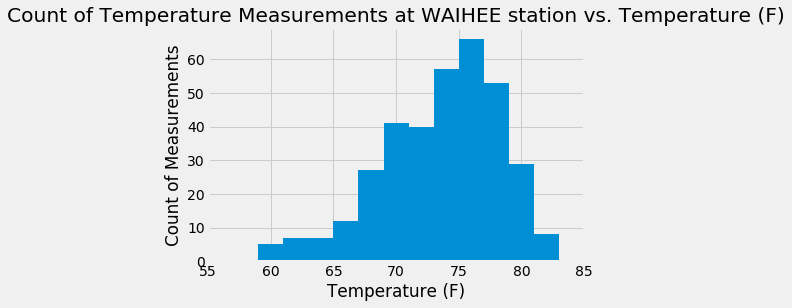

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_temp_for_most_active_station = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').\
                                        filter(Measurement.date >= '2016-08-23').order_by(Measurement.date).all()
print("There were {} measurements for the most active station (WAIHEE) in the last year, from 2016-08-23 to 2017-08-23!"
      .format(len(last_year_temp_for_most_active_station)))

last_year_df = pd.DataFrame(last_year_temp_for_most_active_station)
hist_axes = last_year_df.hist(bins=12)[0][0]

hist_axes.set_title("Count of Temperature Measurements at WAIHEE station vs. Temperature (F)")
hist_axes.set_xlim(55, 85)
hist_axes.set_xlabel("Temperature (F)")
hist_axes.set_ylabel("Count of Measurements")

## Bonus Challenge Assignment

### Temperature Analysis I
* Determine if there is a significant difference in temperature between June and December

In [37]:
from scipy.stats import ttest_ind

all_junes = session.query(Measurement.date, Measurement.tobs).filter(func.strftime("%m", Measurement.date) == "06").all()
all_dec = session.query(Measurement.date, Measurement.tobs).filter(func.strftime("%m", Measurement.date) == "12").all()

#get june average temperatures for each year
all_june_df = pd.DataFrame(all_junes)
all_june_df = all_june_df.dropna()
all_june_df.date = pd.to_datetime(all_june_df.date)
all_june_df["year"] = all_june_df["date"].apply(lambda x: x.year)
june_avg = all_june_df.groupby("year").mean()

#get december average temperatures for each year
all_dec_df = pd.DataFrame(all_dec)
all_dec_df = all_dec_df.dropna()
all_dec_df.date = pd.to_datetime(all_dec_df.date)
all_dec_df["year"] = all_dec_df["date"].apply(lambda x: x.year)
dec_avg = all_dec_df.groupby("year").mean()

print(june_avg, dec_avg)
print("")

#use an unpaired (independent) t-test to determine if the temperature differences are significant
(t_val, p_val) = ttest_ind(june_avg["tobs"], dec_avg["tobs"])
if(p_val<0.05):
    print(f"The unpaired t-test p-value is {p_val} and is less than 0.05, so the results are significant and there is a meaningful difference in the "+
         "temperatures between June and December, suggesting some seasonal change.")
else:
    print(f"The unpaired t-test p-value is {p_val} and is greater than 0.05, so the results are not significant and there is no meaningful difference in the "+
         "temperatures between June and December, suggesting no seasonal change.")

           tobs
year           
2010  74.925620
2011  73.938326
2012  74.000000
2013  74.599078
2014  75.027907
2015  74.990148
2016  75.175258
2017  77.219895            tobs
year           
2010  70.208511
2011  70.820628
2012  71.188073
2013  71.094017
2014  69.896861
2015  73.423913
2016  71.130000

The unpaired t-test p-value is 9.681543069110451e-06 and is less than 0.05, so the results are significant and there is a meaningful difference in the temperatures between June and December, suggesting some seasonal change.


### Temperature Analysis II
* Bar plot of average, min, and max temperatures over vacation date range (02-12 to 02-15)

In [39]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [79]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#pretend trip was 2018 or later, so use the 2017 data as the "last year" before the trip

(min_T, avg_T, max_T) = (calc_temps("2017-02-12", "2017-02-15")[0])
avg_T_df = pd.DataFrame({"Temp (F)":[avg_T]})
print(min_T, avg_T, max_T)
avg_T_df

65.0 73.84615384615384 80.0


,Temp (F)
0,73.846154


[]

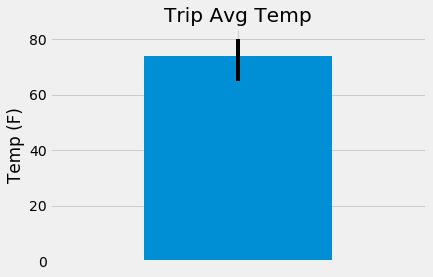

In [80]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
temp_axes = avg_T_df.plot(kind="bar", yerr=[[[avg_T-min_T], [max_T-avg_T]]], legend=False, title="Trip Avg Temp")
temp_axes.set_ylabel("Temp (F)")
temp_axes.set_xticklabels("")

### Daily Temperature Average Normals
* Shows the daily temperatures during trip duration

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [81]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [89]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = dt.datetime(2017, 2, 12)
end_date = dt.datetime(2017, 2, 15)

# Use the start and end date to create a range of dates
change_day = dt.timedelta(days=1)
curr_day = start_date
trip_dates = []
while(curr_day <= end_date):
    trip_dates.append(curr_day)
    curr_day += change_day

# Strip off the year and save a list of %m-%d strings
stripped_trip_dates = list(map(lambda x: x.strftime("%m-%d"), trip_dates))

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(day)[0] for day in stripped_trip_dates]
normals

[(60.0, 69.15789473684211, 78.0),
 (58.0, 70.36206896551724, 80.0),
 (62.0, 70.89473684210526, 79.0),
 (56.0, 70.28813559322033, 79.0)]

In [90]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_results = pd.DataFrame({"Min Temp (F)":[a[0] for a in normals],
                               "Avg Temp (F)":[a[1] for a in normals],
                               "Max Temp (F)":[a[2] for a in normals]}, index=trip_dates)
normals_results

,Min Temp (F),Avg Temp (F),Max Temp (F)
2017-02-12,60.0,69.157895,78.0
2017-02-13,58.0,70.362069,80.0
2017-02-14,62.0,70.894737,79.0
2017-02-15,56.0,70.288136,79.0


(0.0, 85)

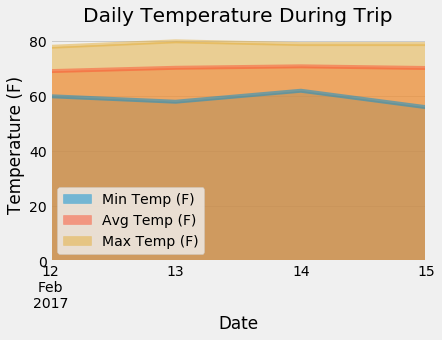

In [106]:
# Plot the daily normals as an area plot with `stacked=False`
normals_axes = normals_results.plot(kind="area", stacked=False, title="Daily Temperature During Trip")
normals_axes.set_ylabel("Temperature (F)")
normals_axes.set_xlabel("Date")
normals_axes.set_ylim(top=85)